In [ ]:
import os
import time
import csv
import numpy as np
from skimage import io
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
import en_core_web_sm
import bcolz
import numpy as np
import pickle
from torch.nn.utils.rnn import pad_sequence
from random import randrange

In [ ]:
FLAGS = {}
FLAGS['data_dir'] = "./data"
FLAGS['batch_size'] = 32
FLAGS['img_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 1e-3
FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 20
FLAGS['num_cores'] = 8 if os.environ.get('TPU_NAME', None) else 1
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [ ]:
device = xm.xla_device()
print(device)

xla:1


# Load Conceptual Captions Dataset

In [ ]:
class CCDataset (Dataset):
    """Conceptual Captions dataset."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with data and mapping.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = data_dir + '/imgs/'
        self.transform = transform
        self.imgs = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f)) and os.path.splitext(f)[1] == '.jpg']
        self.labels = {}
        with open(os.path.join(data_dir, 'mappings.csv')) as csvfile:
            r = csv.reader(csvfile, delimiter=',', quotechar='|')
            try:
                for row in r:
                    self.labels[row[0]] = row[1]
            except:
                pass
            
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_dir + self.imgs[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        if image.shape[0] != 3:
            raise Exception()
        label = self.labels[self.imgs[idx].replace('.jpg', '')]
        if not label:
            raise Exception()
        return image, label

# Load vocabulary and define transforms

In [ ]:
mean = [0.5145, 0.4929, 0.4645]
std = [0.2416, 0.2351, 0.2416]

transform = transforms.Compose([
    transforms.Resize((FLAGS['img_size'], FLAGS['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

tmp_ds = CCDataset(data_dir=FLAGS['data_dir'], transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(tmp_ds, [len(tmp_ds)-(len(tmp_ds)//5), len(tmp_ds)//5])

token_transform = get_tokenizer('spacy', language='en_core_web_sm')
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def yield_tokens(data_iter):
    for i, data_sample in enumerate(data_iter):
        yield token_transform(data_sample[1])
        if i % 100 == 0:
            print(str(round(float(i/len(data_iter))*100.0, 4)) + '% Complete', end='\r')

try:
    vocab_transform = torch.load('vocab_transform.pth')
except:
    print('Building Vocab')
    vocab_transform = build_vocab_from_iterator(yield_tokens(train_dataset),
                                                min_freq=1,
                                                specials=special_symbols,
                                                special_first=True)
    vocab_transform.set_default_index(UNK_IDX)
    print('')
    print('Saving Vocab')
    torch.save(vocab_transform, 'vocab_transform.pth')
    print('Done')

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(token_transform, #Tokenization
                                       vocab_transform, #Numericalization
                                       tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    lbl_batch = []
    img_batch = []
    for data in batch:
        lbl_batch.append(text_transform(data[1]))
        img_batch.append(data[0])
    lbl_batch = pad_sequence(lbl_batch, padding_value=PAD_IDX)
    return torch.stack(img_batch), lbl_batch

In [ ]:
train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal())
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=FLAGS['batch_size'],
    sampler=train_sampler,
    num_workers=FLAGS['num_workers'],
    drop_last=True,
    collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=FLAGS['batch_size'],
    shuffle=False,
    num_workers=FLAGS['num_workers'],
    drop_last=True,
    collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


birthday party ideas photo of 36


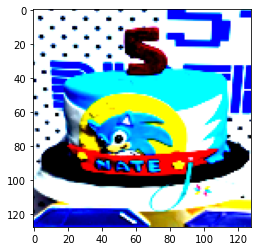

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


instructions on how to be a cat


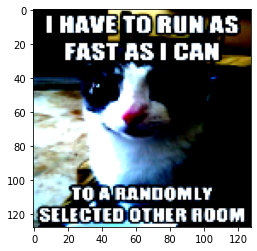

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fishing boats in the old harbor


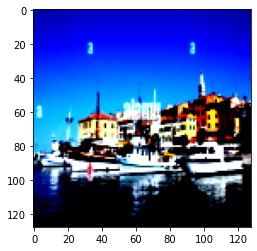

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


musical artist performing the music of composer and violist on sunday afternoon


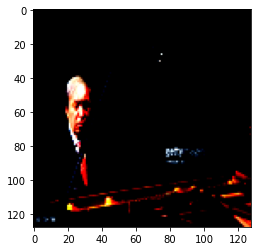

In [ ]:
labels = {}
with open(os.path.join(FLAGS['data_dir'], 'mappings.csv')) as csvfile:
    r = csv.reader(csvfile, delimiter=',', quotechar='|')
    try:
        for row in r:
            labels[row[0]] = row[1]
    except:
        pass

img, label = train_dataset[100]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
img, label = train_dataset[101]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
img, label = train_dataset[102]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
img, label = train_dataset[103]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Vector Quantization Layer
Adapted from https://github.com/zalandoresearch/pytorch-vq-vae

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(input_shape[0], input_shape[1], input_shape[1])

# Encoder, Decoder, and Model
Inspired by ResNet and DALL-E

In [ ]:
class EncoderBlock (nn.Module):
    def __init__(self, n_in, n_out, downsample=False):
        super(EncoderBlock, self).__init__()
        self.n_hidden = n_out // 2

        if n_in == n_out and downsample:
          self.res = nn.AvgPool2d(kernel_size=2, stride=2)
        elif n_in == n_out and not downsample:
          self.res = nn.Identity()
        elif n_in != n_out and downsample:
          self.res = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2)
        else:
          self.res = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1)

        self.enc_block = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(n_in),
            nn.Conv2d(in_channels=n_in, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=2, stride=2) if downsample else nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=n_out, kernel_size=1),
        )


    def forward(self, x):
        return self.enc_block(x) + self.res(x)

In [ ]:
class DecoderBlock (nn.Module):
    def __init__(self, n_in, n_out, upsample=False):
        super(DecoderBlock, self).__init__()

        self.n_hidden = n_out // 2

        if n_in == n_out and upsample:
#           self.res = nn.Upsample(scale_factor=2, mode='nearest')
          self.res = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=2, stride=2)
        elif n_in == n_out and not upsample:
          self.res = nn.Identity()
        elif n_in != n_out and upsample:
          self.res = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2, padding=1)
        else:
          self.res = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1)

        self.enc_block = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(n_in),
            nn.Conv2d(in_channels=n_in, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.ConvTranspose2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=2, stride=2) if upsample else nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=n_out, kernel_size=1),
        )


    def forward(self, x):
        return self.enc_block(x) + self.res(x)

In [ ]:
# Convolutional Autoencoder: ResNet/DALL-E inspired
class ConvAutoencoder(nn.Module):
    def __init__(self, img_size):
        super(ConvAutoencoder, self).__init__()
        self.img_size = img_size

        n_blk = 6
        scale_every = 2 # Downsample/upsample every n blocks
        n_hid = 256
        bottleneck_hid = 1
        
        self.pre_fc_size = int(math.floor(float(img_size)*pow(0.5, scale_every))**2*n_hid)
        self.post_fc_hid = n_hid
        self.post_fc_dim = int(math.floor(float(img_size)*pow(0.5, scale_every)))

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_hid, kernel_size=7, padding=3)

        enc_blocks = []
        for i in range(n_blk):
          enc_blocks.append(EncoderBlock(n_in=n_hid, n_out=n_hid, downsample=((i+1) % scale_every == 0)))

        self.enc_block = nn.Sequential(*enc_blocks)
        
        self.vq = VectorQuantizer(512, n_hid, 0.25)

#         self.bottleneck_in = nn.Sequential(
#             nn.ReLU(),
#             nn.BatchNorm2d(n_hid),
#             nn.Conv2d(in_channels=n_hid, out_channels=bottleneck_hid, kernel_size=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(bottleneck_hid)
#         )
        
        self.bottleneck_out = nn.Sequential(
            nn.ConvTranspose2d(in_channels=bottleneck_hid, out_channels=256, kernel_size=1)
        )

        dec_blocks = []
        for i in range(n_blk):
          dec_blocks.append(DecoderBlock(n_in=n_hid, n_out=n_hid, upsample=((i+1) % scale_every == 0)))

        self.dec_block = nn.Sequential(*dec_blocks)

        self.conv2 = nn.Conv2d(in_channels=n_hid, out_channels=3, kernel_size=1)


    def forward(self, x):
      x = self.conv1(x)
      x = self.enc_block(x)
      loss, quantized, _, encoded = self.vq(x)
#       x = self.bottleneck_out(quantized)
      x = self.dec_block(quantized)
      x = self.conv2(x)
      return x, loss, encoded


#Instantiate the model
img_model = ConvAutoencoder(FLAGS['img_size']).to(device)
img_model.load_state_dict(torch.load('./img_model'))
img_model.eval()
print(img_model)

ConvAutoencoder(
  (conv1): Conv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (enc_block): Sequential(
    (0): EncoderBlock(
      (res): Identity()
      (enc_block): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU()
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): EncoderBlock

# Positional Encoding, Token Embedding, and Transformer
Adapted from https://pytorch.org/tutorials/beginner/translation_transformer.html

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [ ]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src,
                trg,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform)
TGT_VOCAB_SIZE = 512
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Train The Model

In [ ]:
def train():
    torch.manual_seed(1)
    
    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        img_model.eval()
        transformer.train()
        for x, data in enumerate(loader):
            src = data[1]
            output, vq_loss, hidden = img_model(data[0])
            tgt = hidden.view(FLAGS['batch_size'], 256).T
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt)
            logits = transformer(src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            optimizer.zero_grad()
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
            loss.backward()
            xm.optimizer_step(optimizer)
            if x % FLAGS['log_steps'] == 0:
                print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f}'.format(
                    xm.get_ordinal(), x, loss.item(), tracker.rate(),
                    tracker.global_rate()), flush=True)
                
    def test_loop_fn(loader, best_loss):
        total_samples = 0
        loss = 0.0
        img_model.eval()
        transformer.eval()
        with torch.no_grad():
            for x, data in enumerate(loader):
                src = data[1]
                output, vq_loss, hidden = img_model(data[0])
                tgt = hidden.view(FLAGS['batch_size'], 256).T
                src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt)
                logits = transformer(src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
                optimizer.zero_grad()
                loss += loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1)).item()
                total_samples += 1

        total_loss = loss / total_samples
        bl = best_loss
        print('[xla:{}] Validation Loss={:.2f}%'.format(
            xm.get_ordinal(), total_loss), flush=True)
        if total_loss < bl:
            print('Saving model...', flush=True)
            torch.save(model.state_dict(), './txt_model')
            bl = total_loss
        return bl
    
    # Train and eval loops
    best_test_loss = 999999
    accuracy = 0.0
    data, pred, target = None, None, None
    for epoch in range(1, FLAGS['num_epochs'] + 1):
        para_loader = pl.ParallelLoader(train_loader, [device])
        train_loop_fn(para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}".format(epoch))
        para_loader = pl.ParallelLoader(test_loader, [device])
        best_test_loss = test_loop_fn(para_loader.per_device_loader(device), best_test_loss)

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train()

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'], start_method='fork')

[xla:0](0) Loss=6.79433 Rate=0.00 GlobalRate=0.00
[xla:0](20) Loss=2.32738 Rate=0.00 GlobalRate=0.00
[xla:0](40) Loss=0.46342 Rate=0.00 GlobalRate=0.00
[xla:0](60) Loss=0.05166 Rate=0.00 GlobalRate=0.00
[xla:0](80) Loss=0.01987 Rate=0.00 GlobalRate=0.00
[xla:0](100) Loss=0.01596 Rate=0.00 GlobalRate=0.00
[xla:0](120) Loss=0.01121 Rate=0.00 GlobalRate=0.00
[xla:0](140) Loss=0.00821 Rate=0.00 GlobalRate=0.00
[xla:0](160) Loss=0.00596 Rate=0.00 GlobalRate=0.00
[xla:0](180) Loss=0.00581 Rate=0.00 GlobalRate=0.00
[xla:0](200) Loss=0.00365 Rate=0.00 GlobalRate=0.00
[xla:0](220) Loss=0.00307 Rate=0.00 GlobalRate=0.00
[xla:0](240) Loss=0.00262 Rate=0.00 GlobalRate=0.00
[xla:0](260) Loss=0.00175 Rate=0.00 GlobalRate=0.00
[xla:0](280) Loss=0.00160 Rate=0.00 GlobalRate=0.00
[xla:0](300) Loss=0.00198 Rate=0.00 GlobalRate=0.00
[xla:0](320) Loss=0.00099 Rate=0.00 GlobalRate=0.00
[xla:0](340) Loss=0.00078 Rate=0.00 GlobalRate=0.00
[xla:0](360) Loss=0.00075 Rate=0.00 GlobalRate=0.00
[xla:0](380) Loss=

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](3600) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3620) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3640) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3660) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3680) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3700) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3720) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3740) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3760) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3780) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3800) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3820) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3840) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3860) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3880) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3900) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3920) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3940) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](3960) Loss=0.00000 Rate=0.00 GlobalRat

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6080) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6100) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6120) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6140) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6160) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6180) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6200) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6220) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6240) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6260) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6280) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6300) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6320) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6340) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6360) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6380) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6400) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6420) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](6440) Loss=0.00000 Rate=0.00 GlobalRat

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](9640) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9660) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9680) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9700) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9720) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9740) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9760) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9780) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9800) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9820) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9840) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9860) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9880) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9900) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9920) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9940) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9960) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](9980) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](10000) Loss=0.00000 Rate=0.00 GlobalRa

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](11540) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11560) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11580) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11600) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11620) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11640) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11660) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11680) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11700) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11720) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11740) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11760) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11780) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11800) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11820) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11840) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11860) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11880) Loss=0.00000 Rate=0.00 GlobalRate=0.00
[xla:0](11900) Loss=0.00000 

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


## Generate

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, latent_size):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    print('encoded ' + str(memory.shape))
    ys = torch.ones(1, 1).fill_(randrange(latent_size)).type(torch.long).to(device)
    for i in range(latent_size-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
    return ys


# actual function to translate input sentence into target language
def translate(model, src_sentence):
    model.eval()
    src = text_transform(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model, src, src_mask, 256).flatten()
    return tgt_tokens

print(translate(transformer, 'A scenic view.'))